In [8]:
import os
import numpy as np
import MinkowskiEngine as ME
import open3d as o3d
from sklearn.cluster import KMeans


def load_point_cloud(file_path):
    point_cloud = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
    return point_cloud


def load_labels(file_path):
    labels = np.fromfile(file_path, dtype=np.uint32).reshape(-1)
    # sem_label = np.fromfile(file_path, dtype=np.int16).reshape(-1)

    return labels


def quantize_point_cloud(point_cloud, labels, voxel_size=0.05):
    # Quantize the point cloud
    coordinates = point_cloud[:, :3]
    features = point_cloud[:, 3:]
    quantized_coords, quantized_features, unique_map, inverse_map = ME.utils.sparse_quantize(
        coordinates=coordinates,
        features=features,
        return_index=True,
        return_inverse=True,
        quantization_size=voxel_size,
    )
    quantized_labels = labels[unique_map]
    return quantized_coords, quantized_features, quantized_labels


def save_data_item(data, velodyne_path, label_path):
    # Combine coordinates and features
    combined = np.hstack((data["coordinates"], data["features"]))
    # Ensure parent directories exist
    os.makedirs(os.path.dirname(velodyne_path), exist_ok=True)
    os.makedirs(os.path.dirname(label_path), exist_ok=True)
    # Save velodyne data
    combined.astype(np.float32).tofile(velodyne_path)
    # Save label data
    data["labels"].astype(np.uint32).tofile(label_path)


def generate_distinct_colors_kmeans(n):
    """
    Generate `n` distinct colors using k-means clustering.

    Args:
        n (int): Number of colors to generate.

    Returns:
        list of tuples: List of RGB color tuples.
    """
    # Sample a large number of colors in RGB space
    np.random.seed(0)
    large_sample = np.random.randint(0, 256, (10000, 3))

    # Apply k-means clustering to find n clusters
    kmeans = KMeans(n_clusters=n, n_init=10).fit(large_sample)
    colors = kmeans.cluster_centers_.astype(int)

    return [tuple(color) for color in colors]


def labels_to_colors(labels):
    """
    Convert labels to colors using a k-means generated colormap.

    Args:
        labels (numpy.ndarray): Array of labels.

    Returns:
        numpy.ndarray: Array of RGB colors.
    """
    # Determine the number of unique labels
    unique_labels = np.unique(labels)
    num_colors = len(unique_labels)

    # Generate distinct colors
    colors_list = generate_distinct_colors_kmeans(num_colors)

    # Create a mapping from labels to colors
    label_to_color = {label: colors_list[i] for i, label in enumerate(unique_labels)}

    # Apply the color map
    colors = np.array([label_to_color[label] for label in labels])
    return colors


def save_pcd(data, output_path):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(data["coordinates"])
    colors = labels_to_colors(data["labels"])[:, :3] / 255
    # colors = labels_to_colors(data["labels"])[:, :3]
    pcd.colors = o3d.utility.Vector3dVector(colors)
    o3d.io.write_point_cloud(output_path, pcd)
    return colors


scan_index = "002503"
file_path = f"/globalwork/data/SemanticKITTI/dataset/sequences/08/velodyne/{scan_index}.bin"
label_path = f"/globalwork/data/SemanticKITTI/dataset/sequences/08/labels/{scan_index}.label"

point_cloud = load_point_cloud(file_path)
labels = load_labels(label_path)
colors = labels_to_colors(labels)[:, :3] / 255
# quantized_coords, quantized_features, quantized_labels = quantize_point_cloud(point_cloud, labels, voxel_size=0.05)
# data_item = {"coordinates": quantized_coords, "features": quantized_features, "labels": quantized_labels}
data_item = {"coordinates": point_cloud[:, 0:3], "features": point_cloud[:, 3], "labels": labels}
output_path = "example.pcd"
save_pcd(data_item, output_path)


# Create Open3D PointCloud object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:, :3])  # XYZ coordinates
pcd.colors = o3d.utility.Vector3dVector(colors)  # RGB colors

# Save as PLY file
output_ply_path = "example.ply"
o3d.io.write_point_cloud(output_ply_path, pcd)


print(point_cloud.shape)

(124997, 4)


In [1]:
import numpy as np
import open3d as o3d

ply_dtypes = dict([(b"int8", "i1"), (b"char", "i1"), (b"uint8", "u1"), (b"uchar", "u1"), (b"int16", "i2"), (b"short", "i2"), (b"uint16", "u2"), (b"ushort", "u2"), (b"int32", "i4"), (b"int", "i4"), (b"uint32", "u4"), (b"uint", "u4"), (b"float32", "f4"), (b"float", "f4"), (b"float64", "f8"), (b"double", "f8")])
# Numpy reader format
valid_formats = {"ascii": "", "binary_big_endian": ">", "binary_little_endian": "<"}


def read_ply(filename, triangular_mesh=False):
    """
    Read ".ply" files
    Parameters
    ----------
    filename : string
        the name of the file to read.
    Returns
    -------
    result : array
    data stored in the file
    Examples
    --------
    Store data in file
    >>> points = np.random.rand(5, 3)
    >>> values = np.random.randint(2, size=10)
    >>> write_ply('example.ply', [points, values], ['x', 'y', 'z', 'values'])
    Read the file
    >>> data = read_ply('example.ply')
    >>> values = data['values']
    array([0, 0, 1, 1, 0])

    >>> points = np.vstack((data['x'], data['y'], data['z'])).T
    array([[ 0.466  0.595  0.324]
           [ 0.538  0.407  0.654]
           [ 0.850  0.018  0.988]
           [ 0.395  0.394  0.363]
           [ 0.873  0.996  0.092]])
    """

    with open(filename, "rb") as plyfile:

        # Check if the file start with ply
        if b"ply" not in plyfile.readline():
            raise ValueError("The file does not start whith the word ply")

        # get binary_little/big or ascii
        fmt = plyfile.readline().split()[1].decode()
        if fmt == "ascii":
            raise ValueError("The file is not binary")

        # get extension for building the numpy dtypes
        ext = valid_formats[fmt]

        # PointCloud reader vs mesh reader
        if triangular_mesh:

            # Parse header
            num_points, num_faces, properties = parse_mesh_header(plyfile, ext)

            # Get point data
            vertex_data = np.fromfile(plyfile, dtype=properties, count=num_points)

            # Get face data
            face_properties = [("k", ext + "u1"), ("v1", ext + "i4"), ("v2", ext + "i4"), ("v3", ext + "i4")]
            faces_data = np.fromfile(plyfile, dtype=face_properties, count=num_faces)

            # Return vertex data and concatenated faces
            faces = np.vstack((faces_data["v1"], faces_data["v2"], faces_data["v3"])).T
            data = [vertex_data, faces]

        else:

            # Parse header
            num_points, properties = parse_header(plyfile, ext)

            # Get data
            data = np.fromfile(plyfile, dtype=properties, count=num_points)

    return data


def parse_header(plyfile, ext):
    # Variables
    line = []
    properties = []
    num_points = None

    while b"end_header" not in line and line != b"":
        line = plyfile.readline()

        if b"element" in line:
            line = line.split()
            num_points = int(line[2])

        elif b"property" in line:
            line = line.split()
            properties.append((line[2].decode(), ext + ply_dtypes[line[1]]))

    return num_points, properties


def parse_mesh_header(plyfile, ext):
    # Variables
    line = []
    vertex_properties = []
    num_points = None
    num_faces = None
    current_element = None

    while b"end_header" not in line and line != b"":
        line = plyfile.readline()

        # Find point element
        if b"element vertex" in line:
            current_element = "vertex"
            line = line.split()
            num_points = int(line[2])

        elif b"element face" in line:
            current_element = "face"
            line = line.split()
            num_faces = int(line[2])

        elif b"property" in line:
            if current_element == "vertex":
                line = line.split()
                vertex_properties.append((line[2].decode(), ext + ply_dtypes[line[1]]))
            elif current_element == "vertex":
                if not line.startswith("property list uchar int"):
                    raise ValueError("Unsupported faces property : " + line)

    return num_points, num_faces, vertex_properties

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
# Define the color map
label_color_map = {1: [1, 211, 211], 2: [233, 138, 0], 3: [41, 207, 2], 4: [244, 0, 128], 5: [194, 193, 3], 6: [121, 59, 50], 7: [254, 180, 214], 8: [239, 1, 51], 9: [125, 0, 237], 10: [229, 14, 241], 11: [222, 40, 0], 12: [0, 120, 231], 13: [110, 218, 96], 14: [253, 94, 83], 15: [153, 85, 187]}

# Read the PLY file
ply_path = "/work/fradlin/Interactive_dataset/interactive4d_data/scene_01_SemanticKITTI_08_000238/label.ply"
pcd = read_ply(ply_path)

# Access the labels
labels = pcd["label"].astype(np.int32)

# Initialize an array for the new colors
new_colors = np.zeros((len(labels), 3), dtype=np.uint8)

# Map each label to the corresponding color
for label, color in label_color_map.items():
    new_colors[labels == label] = color

# Update the point cloud with the new colors
pcd["red"] = new_colors[:, 0]
pcd["green"] = new_colors[:, 1]
pcd["blue"] = new_colors[:, 2]

write_ply(ply_path, [pcd], ["x", "y", "z", "red", "green", "blue"])
ply_path = "/work/fradlin/Interactive_dataset/interactive4d_data/scene_01_SemanticKITTI_08_000238/scan.ply"
write_ply(ply_path, [pcd], ["x", "y", "z", "red", "green", "blue"])

# Convert the updated PLY data to an Open3D point cloud
o3d_pcd = o3d.geometry.PointCloud()
o3d_pcd.points = o3d.utility.Vector3dVector(np.vstack([pcd["x"], pcd["y"], pcd["z"]]).T)
o3d_pcd.colors = o3d.utility.Vector3dVector(new_colors / 255.0)  # Normalize colors to [0, 1] range for Open3D

# Visualize the point cloud
# o3d.visualization.draw_geometries([o3d_pcd])

# Optionally, save the updated point cloud to a new PLY file
# o3d.io.write_point_cloud("updated_label.ply", o3d_pcd)

Traceback (most recent call last):
  File "_pydevd_bundle/pydevd_cython.pyx", line 577, in _pydevd_bundle.pydevd_cython.PyDBFrame._handle_exception
  File "_pydevd_bundle/pydevd_cython.pyx", line 312, in _pydevd_bundle.pydevd_cython.PyDBFrame.do_wait_suspend
  File "/home/fradlin/miniconda3/envs/mask4d/lib/python3.8/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2070, in do_wait_suspend
    keep_suspended = self._do_wait_suspend(thread, frame, event, arg, suspend_type, from_this_thread, frames_tracker)
  File "/home/fradlin/miniconda3/envs/mask4d/lib/python3.8/site-packages/debugpy/_vendored/pydevd/pydevd.py", line 2106, in _do_wait_suspend
    time.sleep(0.01)
KeyboardInterrupt


NameError: name 'read_ply' is not defined

In [2]:
import numpy as np
from PIL import Image, ImageDraw

# Define the color map
label_color_map = {1: [1, 211, 211], 2: [233, 138, 0], 3: [41, 207, 2], 4: [244, 0, 128], 5: [194, 193, 3], 6: [121, 59, 50], 7: [254, 180, 214], 8: [239, 1, 51], 9: [125, 0, 237], 10: [229, 14, 241], 11: [222, 40, 0], 12: [0, 120, 231], 13: [110, 218, 96], 14: [253, 94, 83], 15: [153, 85, 187]}

# Define the size of each color box and the spacing
box_size = 50
spacing = 10

# Calculate the image size
num_labels = len(label_color_map)
image_width = box_size + 100  # additional space for label text
image_height = num_labels * (box_size + spacing)

# Create a blank image
image = Image.new("RGB", (image_width, image_height), color="white")
draw = ImageDraw.Draw(image)

# Draw the color boxes with labels
for i, (label, color) in enumerate(label_color_map.items()):
    y_position = i * (box_size + spacing)
    # Draw the color box
    draw.rectangle([0, y_position, box_size, y_position + box_size], fill=tuple(color))
    # Draw the label text
    draw.text((box_size + spacing, y_position + box_size // 4), f"Label {label}", fill="black")

# Save the image
image.save("color_map_visualization.png")

In [9]:
import json
from pathlib import Path

dir_path = Path("/nodes/veltins/work/fradlin/jsons")
new_json_file = dir_path.joinpath(dir_path, "semantickitti_ablation_validation_list.json")
with open(new_json_file) as f:
    data = json.load(f)
data.keys()

dict_keys(['scene_08_000000', 'scene_08_000015', 'scene_08_000030', 'scene_08_000045', 'scene_08_000060', 'scene_08_000075', 'scene_08_000090', 'scene_08_000105', 'scene_08_000120', 'scene_08_000135', 'scene_08_000150', 'scene_08_000165', 'scene_08_000180', 'scene_08_000195', 'scene_08_000210', 'scene_08_000225', 'scene_08_000240', 'scene_08_000255', 'scene_08_000270', 'scene_08_000285', 'scene_08_000300', 'scene_08_000315', 'scene_08_000330', 'scene_08_000345', 'scene_08_000360', 'scene_08_000375', 'scene_08_000390', 'scene_08_000405', 'scene_08_000420', 'scene_08_000435', 'scene_08_000450', 'scene_08_000465', 'scene_08_000480', 'scene_08_000495', 'scene_08_000510', 'scene_08_000525', 'scene_08_000540', 'scene_08_000555', 'scene_08_000570', 'scene_08_000585', 'scene_08_000600', 'scene_08_000615', 'scene_08_000630', 'scene_08_000645', 'scene_08_000660', 'scene_08_000675', 'scene_08_000690', 'scene_08_000705', 'scene_08_000720', 'scene_08_000735', 'scene_08_000750', 'scene_08_000765', '

In [3]:
import numpy as np
from PIL import Image, ImageDraw

# Define the color map
label_color_map = {1: [1, 211, 211], 2: [233, 138, 0], 3: [41, 207, 2], 4: [244, 0, 128], 5: [194, 193, 3], 6: [121, 59, 50], 7: [254, 180, 214], 8: [239, 1, 51], 9: [85, 85, 85], 10: [229, 14, 241]}
# Define the size of each color box and the spacing
box_size = 50
spacing = 10

# Calculate the image size
num_labels = len(label_color_map)
image_width = box_size + 100  # additional space for label text
image_height = num_labels * (box_size + spacing)

# Create a blank image
image = Image.new("RGB", (image_width, image_height), color="white")
draw = ImageDraw.Draw(image)

# Draw the color boxes with labels
for i, (label, color) in enumerate(label_color_map.items()):
    y_position = i * (box_size + spacing)
    # Draw the color box
    draw.rectangle([0, y_position, box_size, y_position + box_size], fill=tuple(color))
    # Draw the label text
    draw.text((box_size + spacing, y_position + box_size // 4), f"Label {label}", fill="black")

# Save the image
image.save("interactive_tool/color_map_visualization.png")

In [7]:
# subsample from the json list only every 15th element
import json
from pathlib import Path

dir_path = Path("/nodes/veltins/work/fradlin/jsons")

json_file = dir_path.joinpath("semantickitti_full_validation_list.json")
with open(json_file) as f:
    data = json.load(f)

# subsample from the json list only every 15th element
subsampled_data = {}
counter = 0
for key, value in data.items():
    # check if divisible by 15
    if counter % 15 == 0:
        subsampled_data[key] = value
    counter += 1


# write the subsampled data to a new file
new_json_file = dir_path.joinpath(dir_path, "semantickitti_ablation_validation_list.json")

with open(new_json_file, "w") as f:
    json.dump(subsampled_data, f)

In [18]:
import open3d as o3d
import os
import numpy as np

scene_3dpoints_file = "/work/fradlin/Interactive_dataset/interactive4d_data/scene_02_KITTI360_0000011079_0000011287/scan.ply"
lable_path = "/work/fradlin/Interactive_dataset/interactive4d_data/scene_02_KITTI360_0000011079_0000011287/label.ply"

point_cloud = read_ply(lable_path)
labels_full_ori = point_cloud["label"].astype(np.int32)

scene_3dpoints = o3d.io.read_point_cloud(scene_3dpoints_file)
scene_3dpoints.points

# self.scene_name, self.scene_point_type, self.points, labels_full_ori, record_file, mask_folder, click_folder, objects = self.dataloader_test.load_scene(curr_scene_idx - 1)
# return name, self.point_type, self.scene_3dpoints, self.labels_full_ori, self.record_path, self.mask_folder, self.click_folder, [self.underscore_to_blank(name) for name in self.scene_object_names]

std::vector<Eigen::Vector3d> with 114692 elements.
Use numpy.asarray() to access data.

In [38]:
import os
import json

with open("/globalwork/fradlin/mask4d-interactive/processed/semantic_kitti/full_train_list.json", "r") as f:
    train_list = json.load(f)

updated_validation_list = {}
for key, item in train_list.items():
    new_item = item
    new_item["number_of_objects"] = len(item["unique_panoptic_labels"])
    updated_validation_list[key] = new_item
    if len(item["unique_panoptic_labels"]) == 10 and "scene_10" in key:
        scan = key.split("_")[2]
        print(item["filepath"])

# write the updated validation list
# with open("train_list.json", "w") as f:
#     json.dump(updated_validation_list, f, indent=4)

/globalwork/data/SemanticKITTI/dataset/sequences/10/velodyne/000003.bin
/globalwork/data/SemanticKITTI/dataset/sequences/10/velodyne/000009.bin
/globalwork/data/SemanticKITTI/dataset/sequences/10/velodyne/000025.bin
/globalwork/data/SemanticKITTI/dataset/sequences/10/velodyne/000026.bin
/globalwork/data/SemanticKITTI/dataset/sequences/10/velodyne/000028.bin
/globalwork/data/SemanticKITTI/dataset/sequences/10/velodyne/000029.bin
/globalwork/data/SemanticKITTI/dataset/sequences/10/velodyne/000030.bin
/globalwork/data/SemanticKITTI/dataset/sequences/10/velodyne/000031.bin
/globalwork/data/SemanticKITTI/dataset/sequences/10/velodyne/000032.bin
/globalwork/data/SemanticKITTI/dataset/sequences/10/velodyne/000035.bin
/globalwork/data/SemanticKITTI/dataset/sequences/10/velodyne/000037.bin
/globalwork/data/SemanticKITTI/dataset/sequences/10/velodyne/000038.bin
/globalwork/data/SemanticKITTI/dataset/sequences/10/velodyne/000039.bin
/globalwork/data/SemanticKITTI/dataset/sequences/10/velodyne/000

In [1]:
import numpy as np
import json
import colorsys
import matplotlib.pyplot as plt

### This Notebook is used for small utility tasks that need to be executed only once


In [7]:
# Load the training JSON file
with open("/globalwork/fradlin/mask4d-interactive/processed/semantic_kitti/full_train_list.json", "r") as f:
    data = json.load(f)

# Initialize a variable to track the maximum length
max_length = 0
min_length = 1000000
max_key = None
min_key = None
running_average = 0
counter = 0

# Iterate over all the keys in the JSON data
for key, value in data.items():
    if "unique_panoptic_labels" in value:
        # Calculate the length of the unique_panoptic_labels list
        length = len(value["unique_panoptic_labels"])
        # Update max_length if the current length is greater
        if length > max_length:
            max_length = length
            max_key = key
        if length < min_length:
            min_length = length
            min_key = key
        running_average += length
        counter += 1

average = running_average / counter

print("stats for training set")
print(f"The average number of unique_panoptic_labels is: {average}")
print(f"The key with the largest unique_panoptic_labels is: {max_key}")
print(f"The largest number of unique_panoptic_labels is: {max_length}")
print(f"The key with the smallest unique_panoptic_labels is: {min_key}")
print(f"The smallest number of unique_panoptic_labels is: {min_length}")

stats for training set
The average number of unique_panoptic_labels is: 19.813904861474125
The key with the largest unique_panoptic_labels is: scene_00_001472
The largest number of unique_panoptic_labels is: 66
The key with the smallest unique_panoptic_labels is: scene_02_001856
The smallest number of unique_panoptic_labels is: 4


In [8]:
# Load the validation JSON file
with open("/globalwork/fradlin/mask4d-interactive/processed/semantic_kitti/full_validation_list.json", "r") as f:
    data = json.load(f)

# Initialize a variable to track the maximum length
max_length = 0
min_length = 1000000
max_key = None
min_key = None
running_average = 0
counter = 0

# Iterate over all the keys in the JSON data
for key, value in data.items():
    if "unique_panoptic_labels" in value:
        # Calculate the length of the unique_panoptic_labels list
        length = len(value["unique_panoptic_labels"])
        # Update max_length if the current length is greater
        if length > max_length:
            max_length = length
            max_key = key
        if length < min_length:
            min_length = length
            min_key = key
        running_average += length
        counter += 1

average = running_average / counter

print("stats for validation set")
print(f"The average number of unique_panoptic_labels is: {average}")
print(f"The key with the largest unique_panoptic_labels is: {max_key}")
print(f"The largest number of unique_panoptic_labels is: {max_length}")
print(f"The key with the smallest unique_panoptic_labels is: {min_key}")
print(f"The smallest number of unique_panoptic_labels is: {min_length}")

stats for validation set
The average number of unique_panoptic_labels is: 24.574551707197248
The key with the largest unique_panoptic_labels is: scene_08_004000
The largest number of unique_panoptic_labels is: 54
The key with the smallest unique_panoptic_labels is: scene_08_000236
The smallest number of unique_panoptic_labels is: 11


### Generate n visually seperable RGB colors


In [17]:
def generate_distinct_colors(n):
    # Generate colors in HSL color space and convert to RGB
    colors = []
    for i in range(n):
        hue = i / n
        lightness = 0.5
        saturation = 0.9
        rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
        rgb = tuple(int(255 * x) for x in rgb)
        colors.append(rgb)
    return colors


# Example usage
n = 70
distinct_colors = generate_distinct_colors(n)
for i, color in enumerate(distinct_colors):
    print(f"Color {i}: {color}")

Color 0: (242, 12, 12)
Color 1: (242, 32, 12)
Color 2: (242, 52, 12)
Color 3: (242, 71, 12)
Color 4: (242, 91, 12)
Color 5: (242, 111, 12)
Color 6: (242, 130, 12)
Color 7: (242, 150, 12)
Color 8: (242, 170, 12)
Color 9: (242, 189, 12)
Color 10: (242, 209, 12)
Color 11: (242, 229, 12)
Color 12: (235, 242, 12)
Color 13: (216, 242, 12)
Color 14: (196, 242, 12)
Color 15: (176, 242, 12)
Color 16: (157, 242, 12)
Color 17: (137, 242, 12)
Color 18: (117, 242, 12)
Color 19: (97, 242, 12)
Color 20: (78, 242, 12)
Color 21: (58, 242, 12)
Color 22: (38, 242, 12)
Color 23: (19, 242, 12)
Color 24: (12, 242, 25)
Color 25: (12, 242, 45)
Color 26: (12, 242, 65)
Color 27: (12, 242, 84)
Color 28: (12, 242, 104)
Color 29: (12, 242, 124)
Color 30: (12, 242, 143)
Color 31: (12, 242, 163)
Color 32: (12, 242, 183)
Color 33: (12, 242, 202)
Color 34: (12, 242, 222)
Color 35: (12, 242, 242)
Color 36: (12, 222, 242)
Color 37: (12, 202, 242)
Color 38: (12, 183, 242)
Color 39: (12, 163, 242)
Color 40: (12, 143, 242)

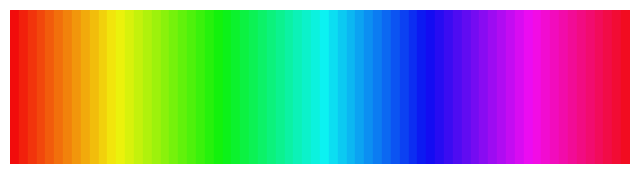

In [18]:
def plot_colors(colors):
    fig, ax = plt.subplots(figsize=(8, 2))
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=[c / 255.0 for c in color]))
    ax.set_xlim(0, len(colors))
    ax.set_ylim(0, 1)
    ax.axis("off")
    plt.show()


plot_colors(distinct_colors)

In [11]:
import matplotlib.pyplot as plt


class IntensityValue:
    def __init__(self, parent, value, level):
        if level > 7:
            raise Exception("There are no more colours left")
        self.value = value
        self.parent = parent
        self.level = level
        self._child_a = None
        self._child_b = None

    @property
    def child_a(self):
        if self._child_a is None:
            self._child_a = IntensityValue(self, self.value - (1 << (7 - self.level)), self.level + 1)
        return self._child_a

    @property
    def child_b(self):
        if self._child_b is None:
            self._child_b = IntensityValue(self, self.value + (1 << (7 - self.level)), self.level + 1)
        return self._child_b


class IntensityValueWalker:
    def __init__(self):
        self.current = IntensityValue(None, 1 << 7, 1)

    def move_next(self):
        if self.current.parent is None:
            self.current = self.current.child_a
        elif self.current.parent.child_a == self.current:
            self.current = self.current.parent.child_b
        else:
            levels_up = 1
            self.current = self.current.parent
            while self.current.parent is not None and self.current == self.current.parent.child_b:
                self.current = self.current.parent
                levels_up += 1
            if self.current.parent is not None:
                self.current = self.current.parent.child_b
            else:
                levels_up += 1
            for _ in range(levels_up):
                self.current = self.current.child_a


class ColourGenerator:
    def __init__(self):
        self.index = 0
        self.intensity_generator = IntensityValueWalker()
        self.patterns = ["{0}0000", "00{0}00", "0000{0}", "{0}{0}00", "{0}00{0}", "00{0}{0}", "{0}{0}{0}"]

    def next_colour(self):
        intensity = self.next_intensity(self.index)
        pattern = self.patterns[self.index % 7]
        colour = pattern.format(intensity)
        self.index += 1
        return colour

    def next_intensity(self, index):
        if index == 0:
            self.current_intensity = 255
        elif index % 7 == 0:
            self.intensity_generator.move_next()
            self.current_intensity = self.intensity_generator.current.value
        current_text = hex(self.current_intensity)[2:].upper()
        if len(current_text) == 1:
            current_text = "0" + current_text
        return current_text


def hex_to_rgb(hex_color):
    return tuple(int(hex_color[i : i + 2], 16) for i in (0, 2, 4))


def plot_colors(colors):
    fig, ax = plt.subplots(figsize=(15, 5))
    for i, color in enumerate(colors):
        rgb = hex_to_rgb(color)
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=[c / 255.0 for c in rgb]))
    ax.set_xlim(0, len(colors))
    ax.set_ylim(0, 1)
    ax.axis("off")
    plt.show()

Color 0: (255, 0, 0)
Color 1: (0, 255, 0)
Color 2: (0, 0, 255)
Color 3: (255, 255, 0)
Color 4: (255, 0, 255)
Color 5: (0, 255, 255)
Color 6: (255, 255, 255)
Color 7: (64, 0, 0)
Color 8: (0, 64, 0)
Color 9: (0, 0, 64)
Color 10: (64, 64, 0)
Color 11: (64, 0, 64)
Color 12: (0, 64, 64)
Color 13: (64, 64, 64)
Color 14: (192, 0, 0)
Color 15: (0, 192, 0)
Color 16: (0, 0, 192)
Color 17: (192, 192, 0)
Color 18: (192, 0, 192)
Color 19: (0, 192, 192)
Color 20: (192, 192, 192)
Color 21: (32, 0, 0)
Color 22: (0, 32, 0)
Color 23: (0, 0, 32)
Color 24: (32, 32, 0)
Color 25: (32, 0, 32)
Color 26: (0, 32, 32)
Color 27: (32, 32, 32)
Color 28: (96, 0, 0)
Color 29: (0, 96, 0)
Color 30: (0, 0, 96)
Color 31: (96, 96, 0)
Color 32: (96, 0, 96)
Color 33: (0, 96, 96)
Color 34: (96, 96, 96)
Color 35: (160, 0, 0)
Color 36: (0, 160, 0)
Color 37: (0, 0, 160)
Color 38: (160, 160, 0)
Color 39: (160, 0, 160)
Color 40: (0, 160, 160)
Color 41: (160, 160, 160)
Color 42: (224, 0, 0)
Color 43: (0, 224, 0)
Color 44: (0, 0, 2

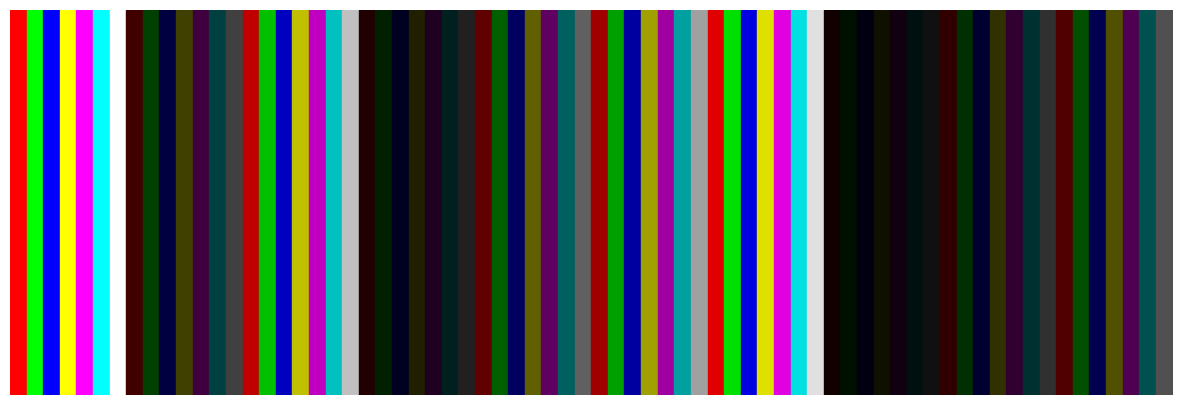

In [12]:
# Example usage
generator = ColourGenerator()
n = 70  # Number of colors to generate
distinct_colors = [generator.next_colour() for _ in range(n)]

for i, color in enumerate(distinct_colors):
    rgb_color = hex_to_rgb(color)
    print(f"Color {i}: {rgb_color}")

# Visualize the colors
plot_colors(distinct_colors)

/home/fradlin/miniconda3/envs/mask4d/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


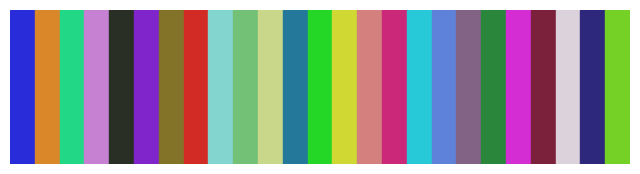

In [24]:
import numpy as np
from sklearn.cluster import KMeans


def generate_distinct_colors_kmeans(n):
    # Sample a large number of colors in RGB space
    np.random.seed(0)
    large_sample = np.random.randint(0, 256, (10000, 3))

    # Apply k-means clustering to find n clusters
    kmeans = KMeans(n_clusters=n).fit(large_sample)
    colors = kmeans.cluster_centers_.astype(int)

    return [tuple(color) for color in colors]


# Example usage
n = 25
distinct_colors_kmeans = generate_distinct_colors_kmeans(n)
# for i, color in enumerate(distinct_colors_kmeans):
#     print(f"Color {i}: {color}")

# Visualize the k-means colors
plot_colors(distinct_colors_kmeans)

70